# Defining Geant4.jl Geometries
Currently we can define G4 geometries by constructing them using the API  of the C++ classes or by reading a GDML file. This notebook will guide you on this task.

It is very convenient to be able to visualize the geometry on the way. For this purpose we need to load the G4Vis extension. This is done this way:


In [1]:
using Geant4
using Geant4.SystemOfUnits                # defines the usints used by Geant4 
using CairoMakie, Rotations, IGLWrap_jll  # to force loading G4Vis extension

## Defining Solids
The first step is to define the solids. The following shapes are defined: `G4Box`, `G4Cons`, `G4Tubs`, `G4Orb`, `G4Sphere`, `G4Trd`, `G4CutTubs`, `G4Para`, `G4Trap`, `G4Torus`, `G4Polycone`, `G4Polyhedra`, `G4EllipticalTube`, `G4Ellipsoid`, `G4EllipticalCone`, `G4Paraboloid`, `G4Hype`, `G4Tet`, `G4ExtrudedSolid`, `G4TwistedBox`, `G4TwistedTrap`, `G4TwistedTrd`, `G4GenericTrap`, `G4TwistedTubs`. In addition there are the boolean shapes: `G4UnionSolid`, `G4SubtractionSolid`, `G4IntersectionSolid`.
The definition of the constructor parameters can be found [documentation](https://geant4-userdoc.web.cern.ch/UsersGuides/ForApplicationDeveloper/html/Detector/Geometry/geomSolids.html#constructed-solid-geometry-csg-solids)

Lets define a tube section like the following

In [2]:
rmin = 10cm
rmax = 20cm
halfz = 10cm
ϕ₀ = 0
Δϕ = 60deg
tube = G4Tubs("tube", rmin, rmax, halfz, ϕ₀, Δϕ ) 

Geant4.G4TubsAllocated(Ptr{Nothing} @0x00000001277fc4e0)

We can easily draw the just constructed solid

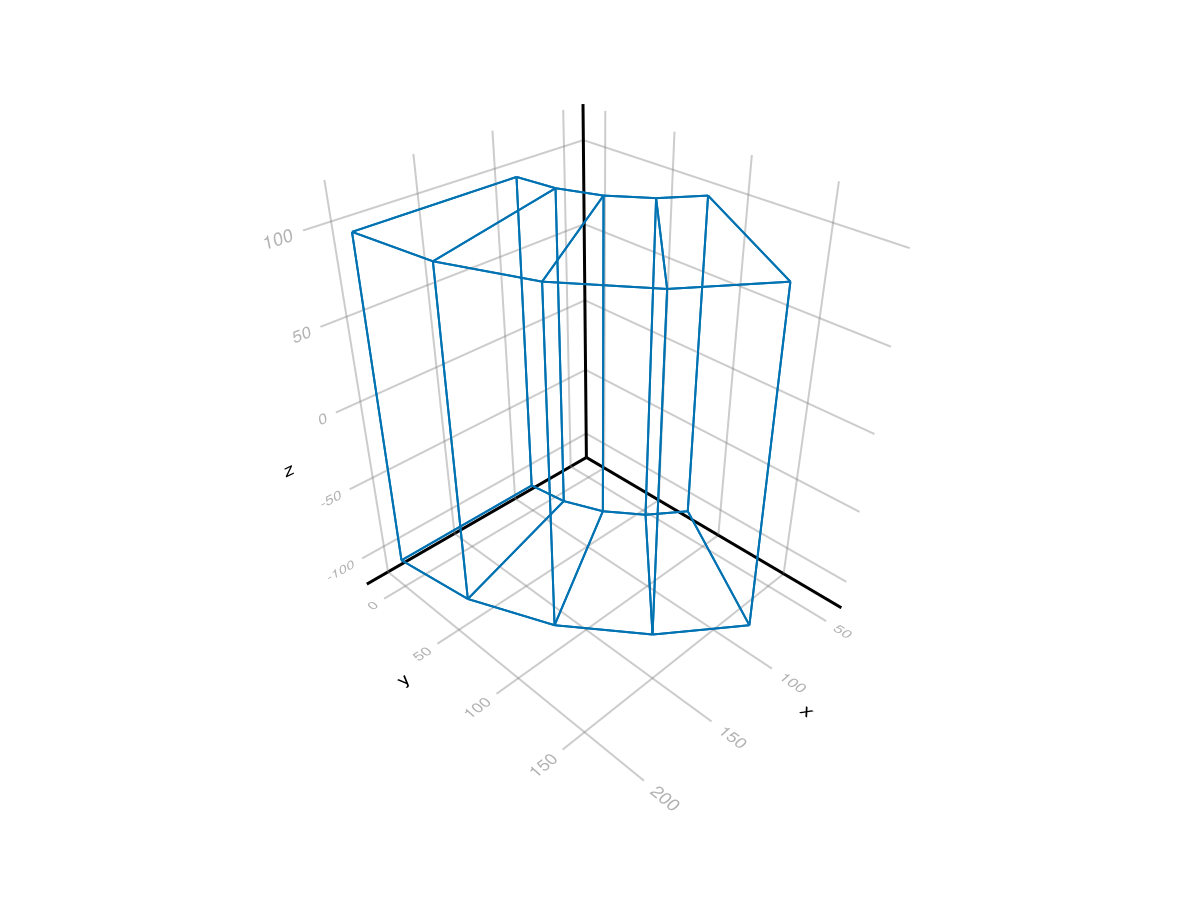

In [3]:
img = draw(tube,  wireframe=true)
display("image/png", img)   # This is needed specially for notebooks

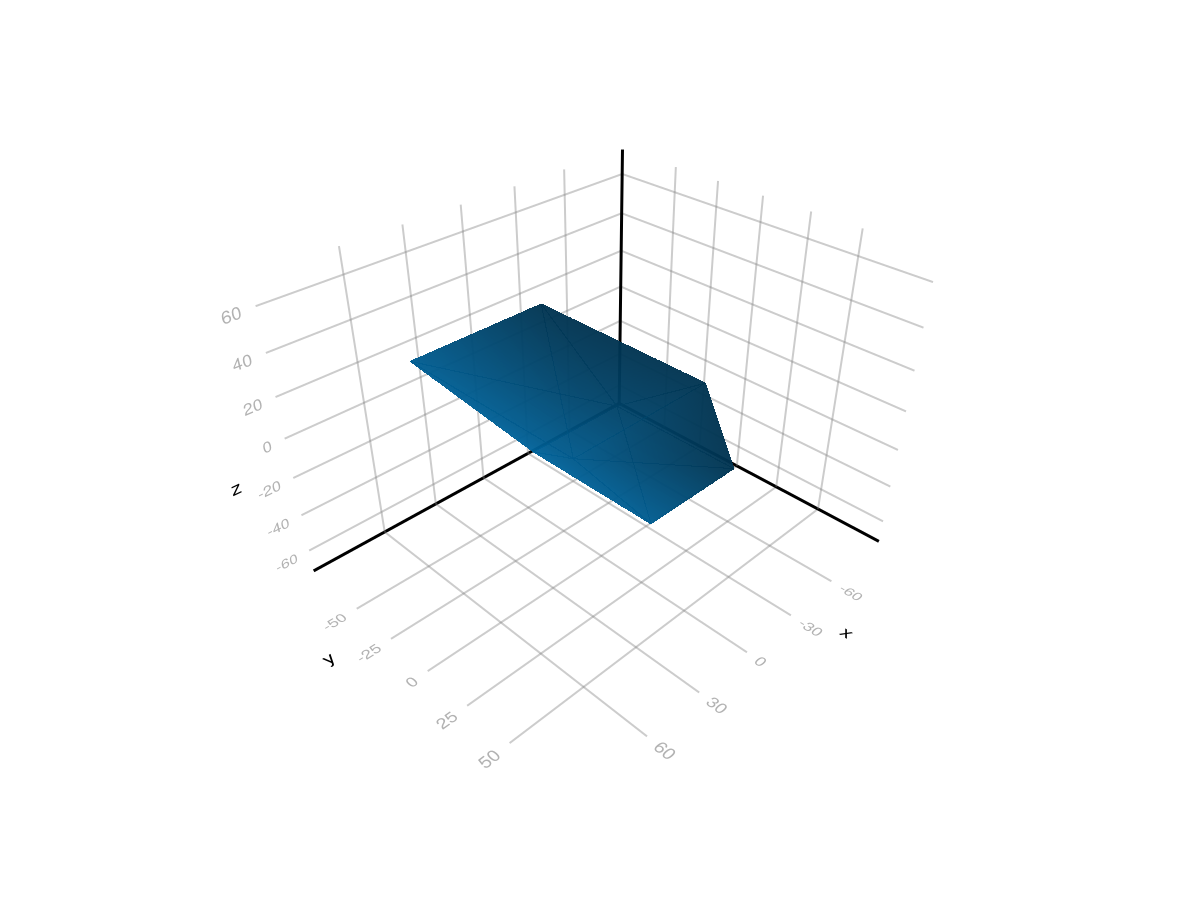

In [4]:
para = G4Para("parallelepiped", 30,40,60,0, π/4, π/6)
img = draw(para)
display("image/png", img)

### Building Boolean solids
We can build more complex geometries by combining with boolean operations simple shapes. For example building a 3D cross. 

In [5]:
box = G4Box("box", 1, 1, 4)
t = G4Transform3D(G4RotationMatrix(0,π/2,0), G4ThreeVector())
cross = G4UnionSolid("cross", CxxPtr(box), CxxPtr(box), t)
img = draw(cross)
isnothing(img) || display("image/png", img)

IGLWrap_jll is not available for currrent platform arm64-apple-darwin22.4.0 and is needed for drawing boolean solids


true

Lets use some geometry functionality to experiment with the created solid

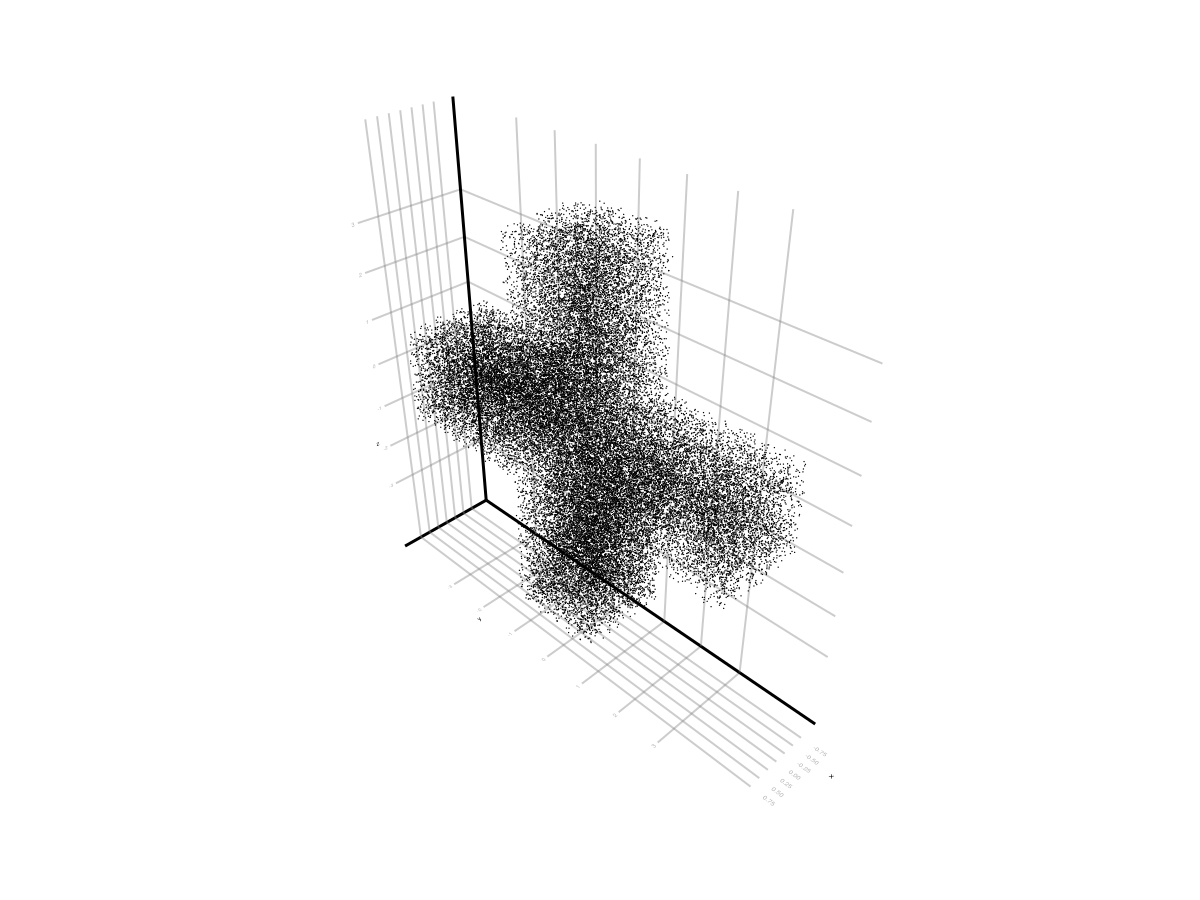

In [6]:
using StaticArrays
const Vector3 = SVector{3}
N = 100000
lo = G4ThreeVector()
hi = G4ThreeVector()
BoundingLimits(cross, lo, hi)                                  # get the bounding limits
dim = hi - lo                 
points = (lo + dim * rp for rp in rand(Vector3{Float64}, N))   # random points within the limits 
result = [Vector3{Float64}(x(p), y(p), z(p)) for p in points if Geant4.Inside(cross, p) == kInside]
img = scatter(result, color=:black, markersize=1)
display("image/png", img)

## Defining Materials
In nature, materials (chemical compounds, mixtures) are made of elements, and elements are made of isotopes. Geant4 offers the 3 classes `G4Isotope`, `G4Element` and `G4Material`to define from first principles any material. However is often that pre-defined materials are available in Geant4 from the [NIST database](https://www.nist.gov/pml/atomic-weights-and-isotopic-compositions-relative-atomic-masses) of elements and isotope compositions.

This is the easiest way to get a material.

In [7]:
nist = G4NistManager!Instance()
m_air = FindOrBuildMaterial(nist, "G4_AIR")
@show GetDensity(m_air)/(g/cm3)

m_water = FindOrBuildMaterial(nist, "G4_WATER")
@show GetDensity(m_water)/(g/cm3)


GetDensity(m_air) / (g / cm3) = 0.0012047899999999999
GetDensity(m_water) / (g / cm3) = 1.0


1.0

or alternatively we can construct it from isotopes

In [8]:
U5 = G4Isotope("U235", z=92, n=235, a=235.01*g/mole)
U8 = G4Isotope("U238", z=92, n=238, a=238.03*g/mole)

U  = G4Element("Enriched Uranium", "U", 2)
AddIsotope(U, move!(U8), 0.90)       # Please notice the use of move!() to transfer ownership 
AddIsotope(U, move!(U5), 0.10)       # Please notice the use of move!() to transfer ownership 

m_eU =  G4Material("enriched U", density= 19.1*g/cm3, ncomponents=1)
AddElement(m_eU, move!(U), natoms=1) # Please notice the use of move!() to transfer ownership 

@show GetDensity(m_eU)/(g/cm3)
@show GetA(m_eU)/(g/mole)


GetDensity(m_eU) / (g / cm3) = 19.1
GetA(m_eU) / (g / mole) = 237.72800000000004


237.72800000000004

or build a molecule

In [9]:
O = FindOrBuildElement(nist, "O")
Si = FindOrBuildElement(nist, "Si")
Lu = FindOrBuildElement(nist, "Lu")
Lu₂SiO₅ = G4Material("Lu2SiO5", density=7.4*g/cm3, ncomponents=3)
AddElement(Lu₂SiO₅, Lu, natoms=2)  # no need to transfer ownership, we just got a pointer not constructed
AddElement(Lu₂SiO₅, Si, natoms=1)  
AddElement(Lu₂SiO₅, O, natoms=5)
@show GetRadlen(Lu₂SiO₅)/cm

GetRadlen(Lu₂SiO₅) / cm = 1.1427324172087883


1.1427324172087883

## Defining Logical Volumes
The Logical Volume manages the information associated with detector elements represented by a given Solid and Material, independently from its physical position in the detector.

To create a G4LogicalVolume just provide a solid and a material

In [10]:
cryst_dX = 6cm
cryst_dY = 6cm
cryst_dZ = 3cm
gap = 0.5mm 

dX = cryst_dX - gap
dY = cryst_dY - gap
solidCryst = G4Box("crystal", dX/2, dY/2, cryst_dZ/2)
logicCryst = G4LogicalVolume(solidCryst, CxxPtr(Lu₂SiO₅), "CrystalLV")


Geant4.G4LogicalVolumeAllocated(Ptr{Nothing} @0x000000028aaa6ab0)

We can also draw a logical volume

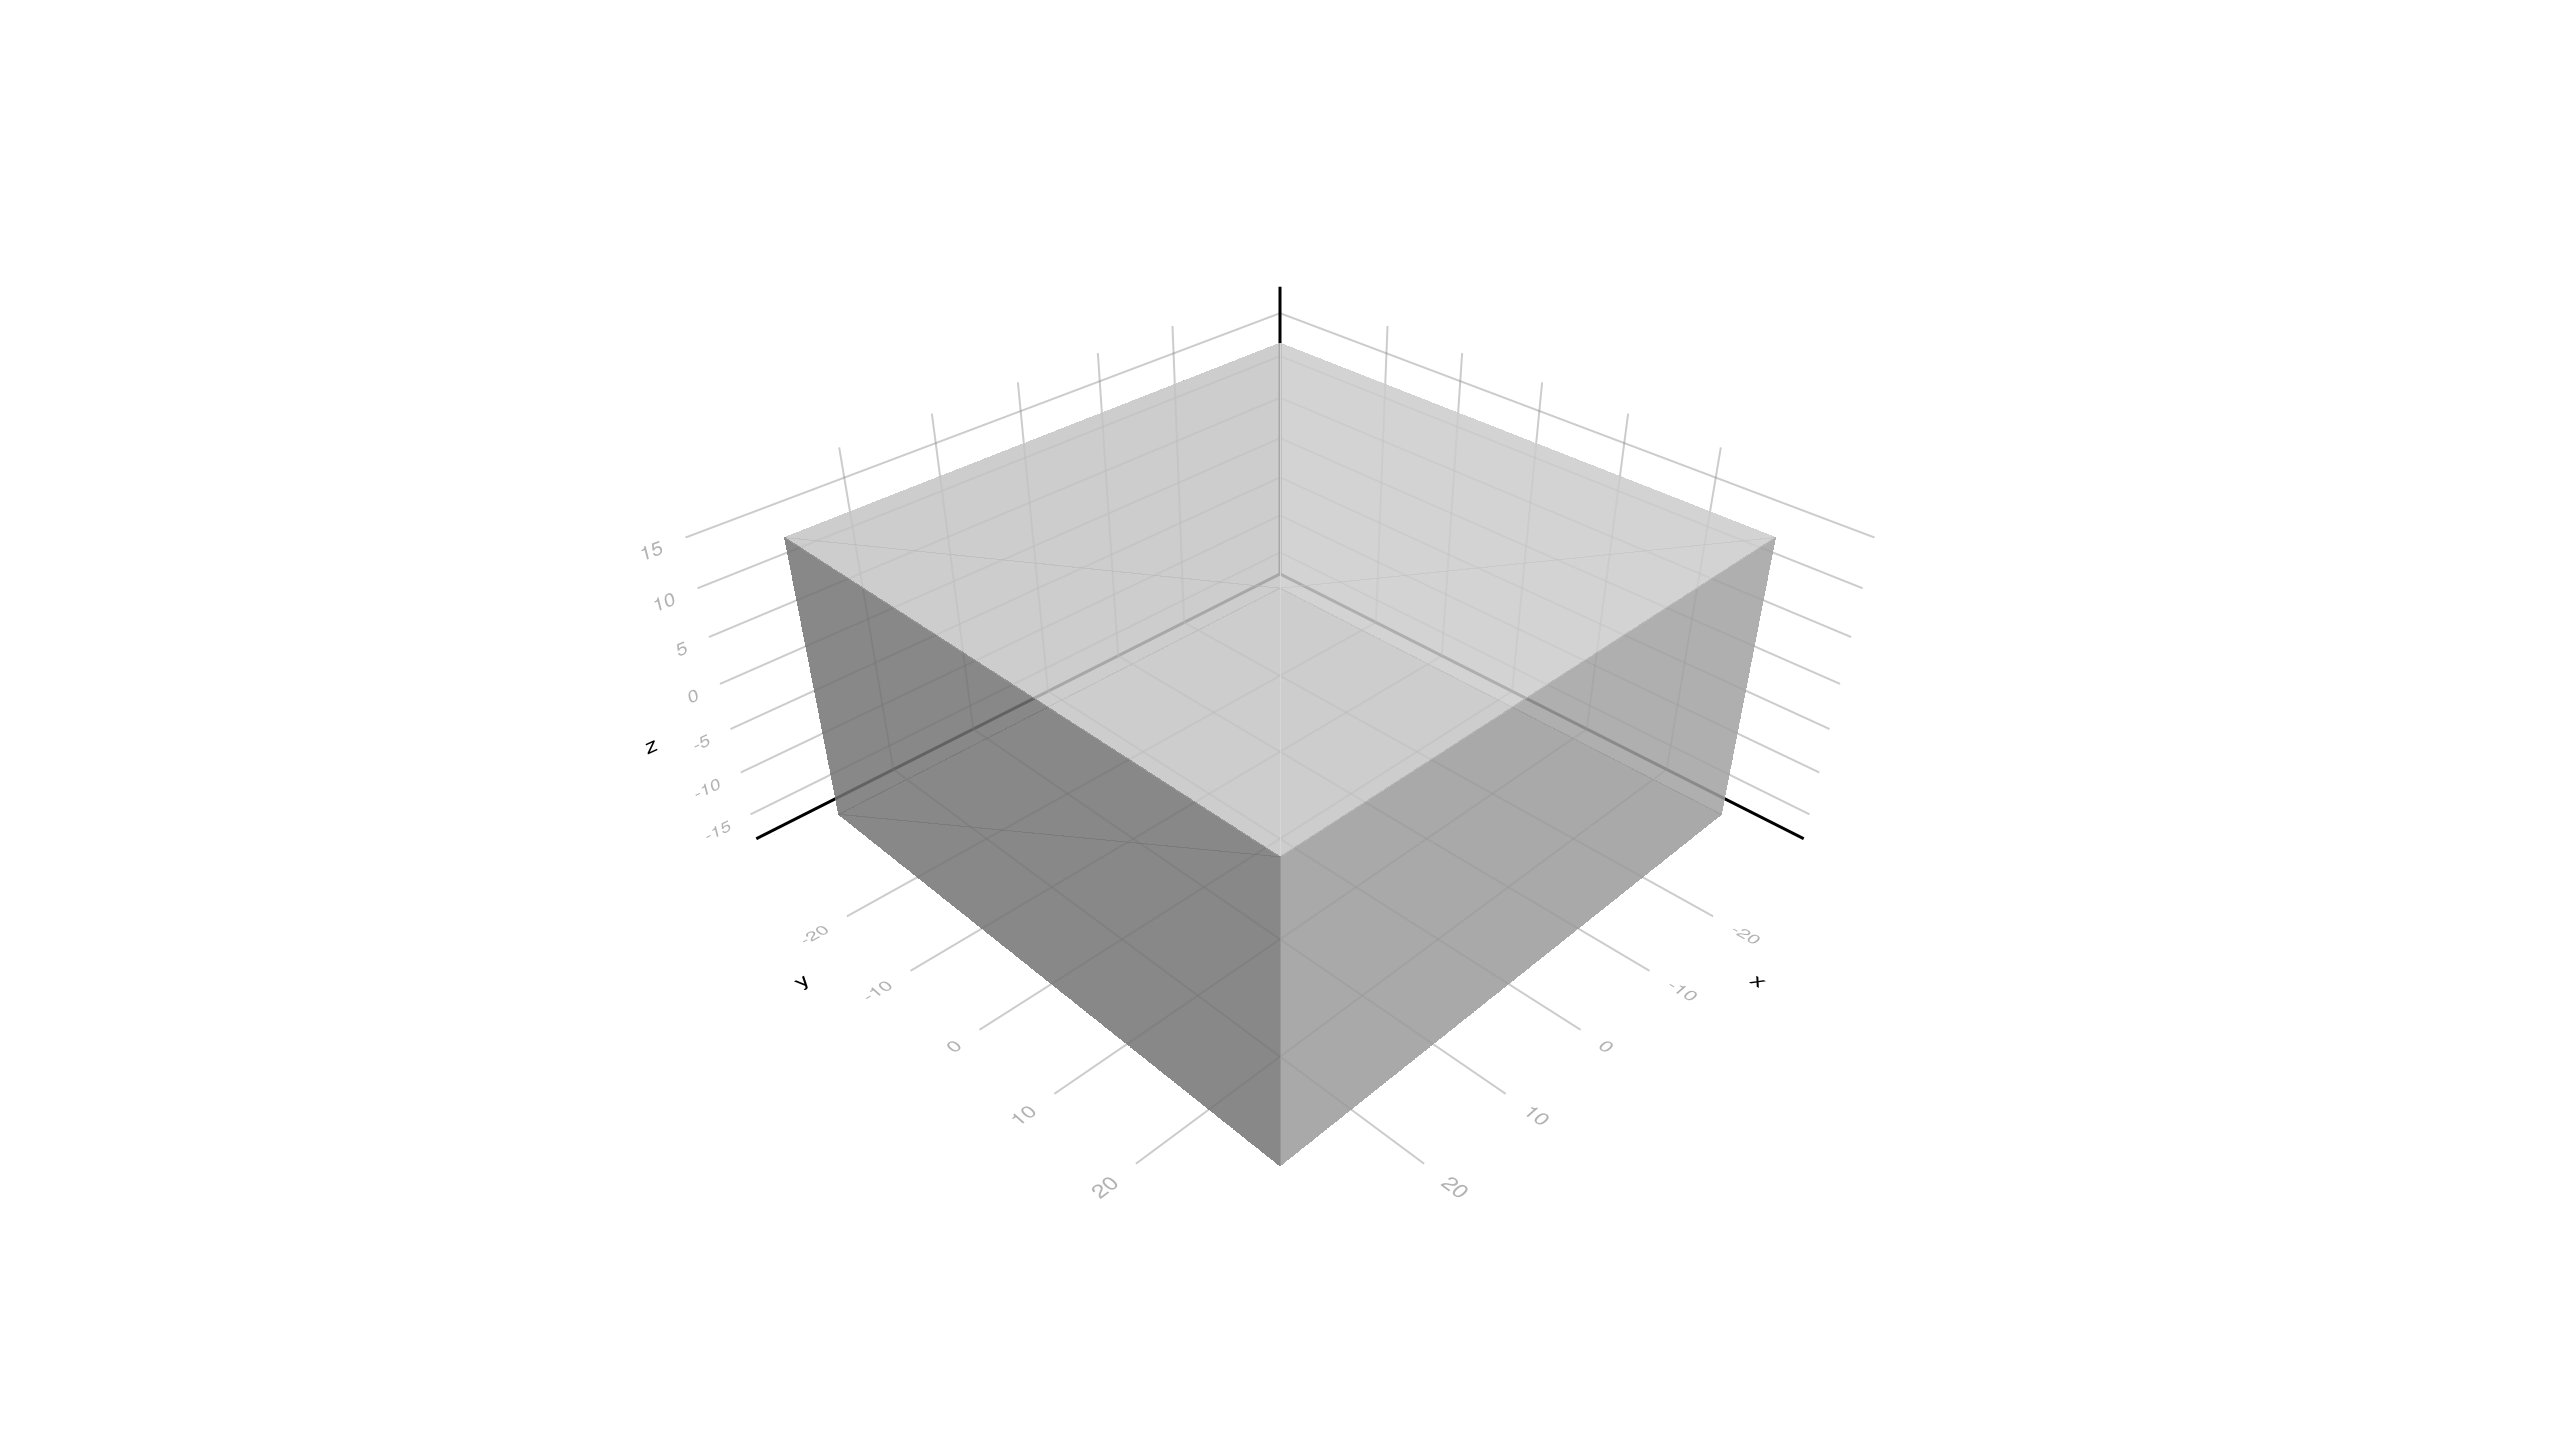

In [11]:
img = draw(logicCryst)
display("image/png", img)

## Placing Logical Volumes
Placing a logical volume (solid+material) inside a mother volume is done by creating a `G4PhysicalVolume`.

In [12]:
nb_cryst = 32
Δϕ = 2π/nb_cryst 
ring_R1 = 0.5 * cryst_dY/tan(Δϕ/2)
ring_R2 = (ring_R1+cryst_dZ)/cos(Δϕ/2)

# mother volume
solidRing = G4Tubs("Ring", ring_R1, ring_R2, cryst_dX/2, 0., 2π)
logicRing = G4LogicalVolume(solidRing, m_air, "Ring")

# placing the crystals
for icrys in 0:nb_cryst-1
    ϕ = icrys*Δϕ
    rotm  = G4RotationMatrix()
    rotateY(rotm, π/2)
    rotateZ(rotm, ϕ)
    position = (ring_R1 + cryst_dZ/2) * G4ThreeVector(cos(ϕ), sin(ϕ), 0)
    transform = G4Transform3D(rotm, position)

    G4PVPlacement(transform,             # rotation,position
                  logicCryst,            # its logical volume
                  "crystal",             # its name
                  logicRing,             # its mother  volume
                  false,                 # no boolean operation
                  icrys,                 # copy number
                  false)                 # checking overlaps
  end

A draw it

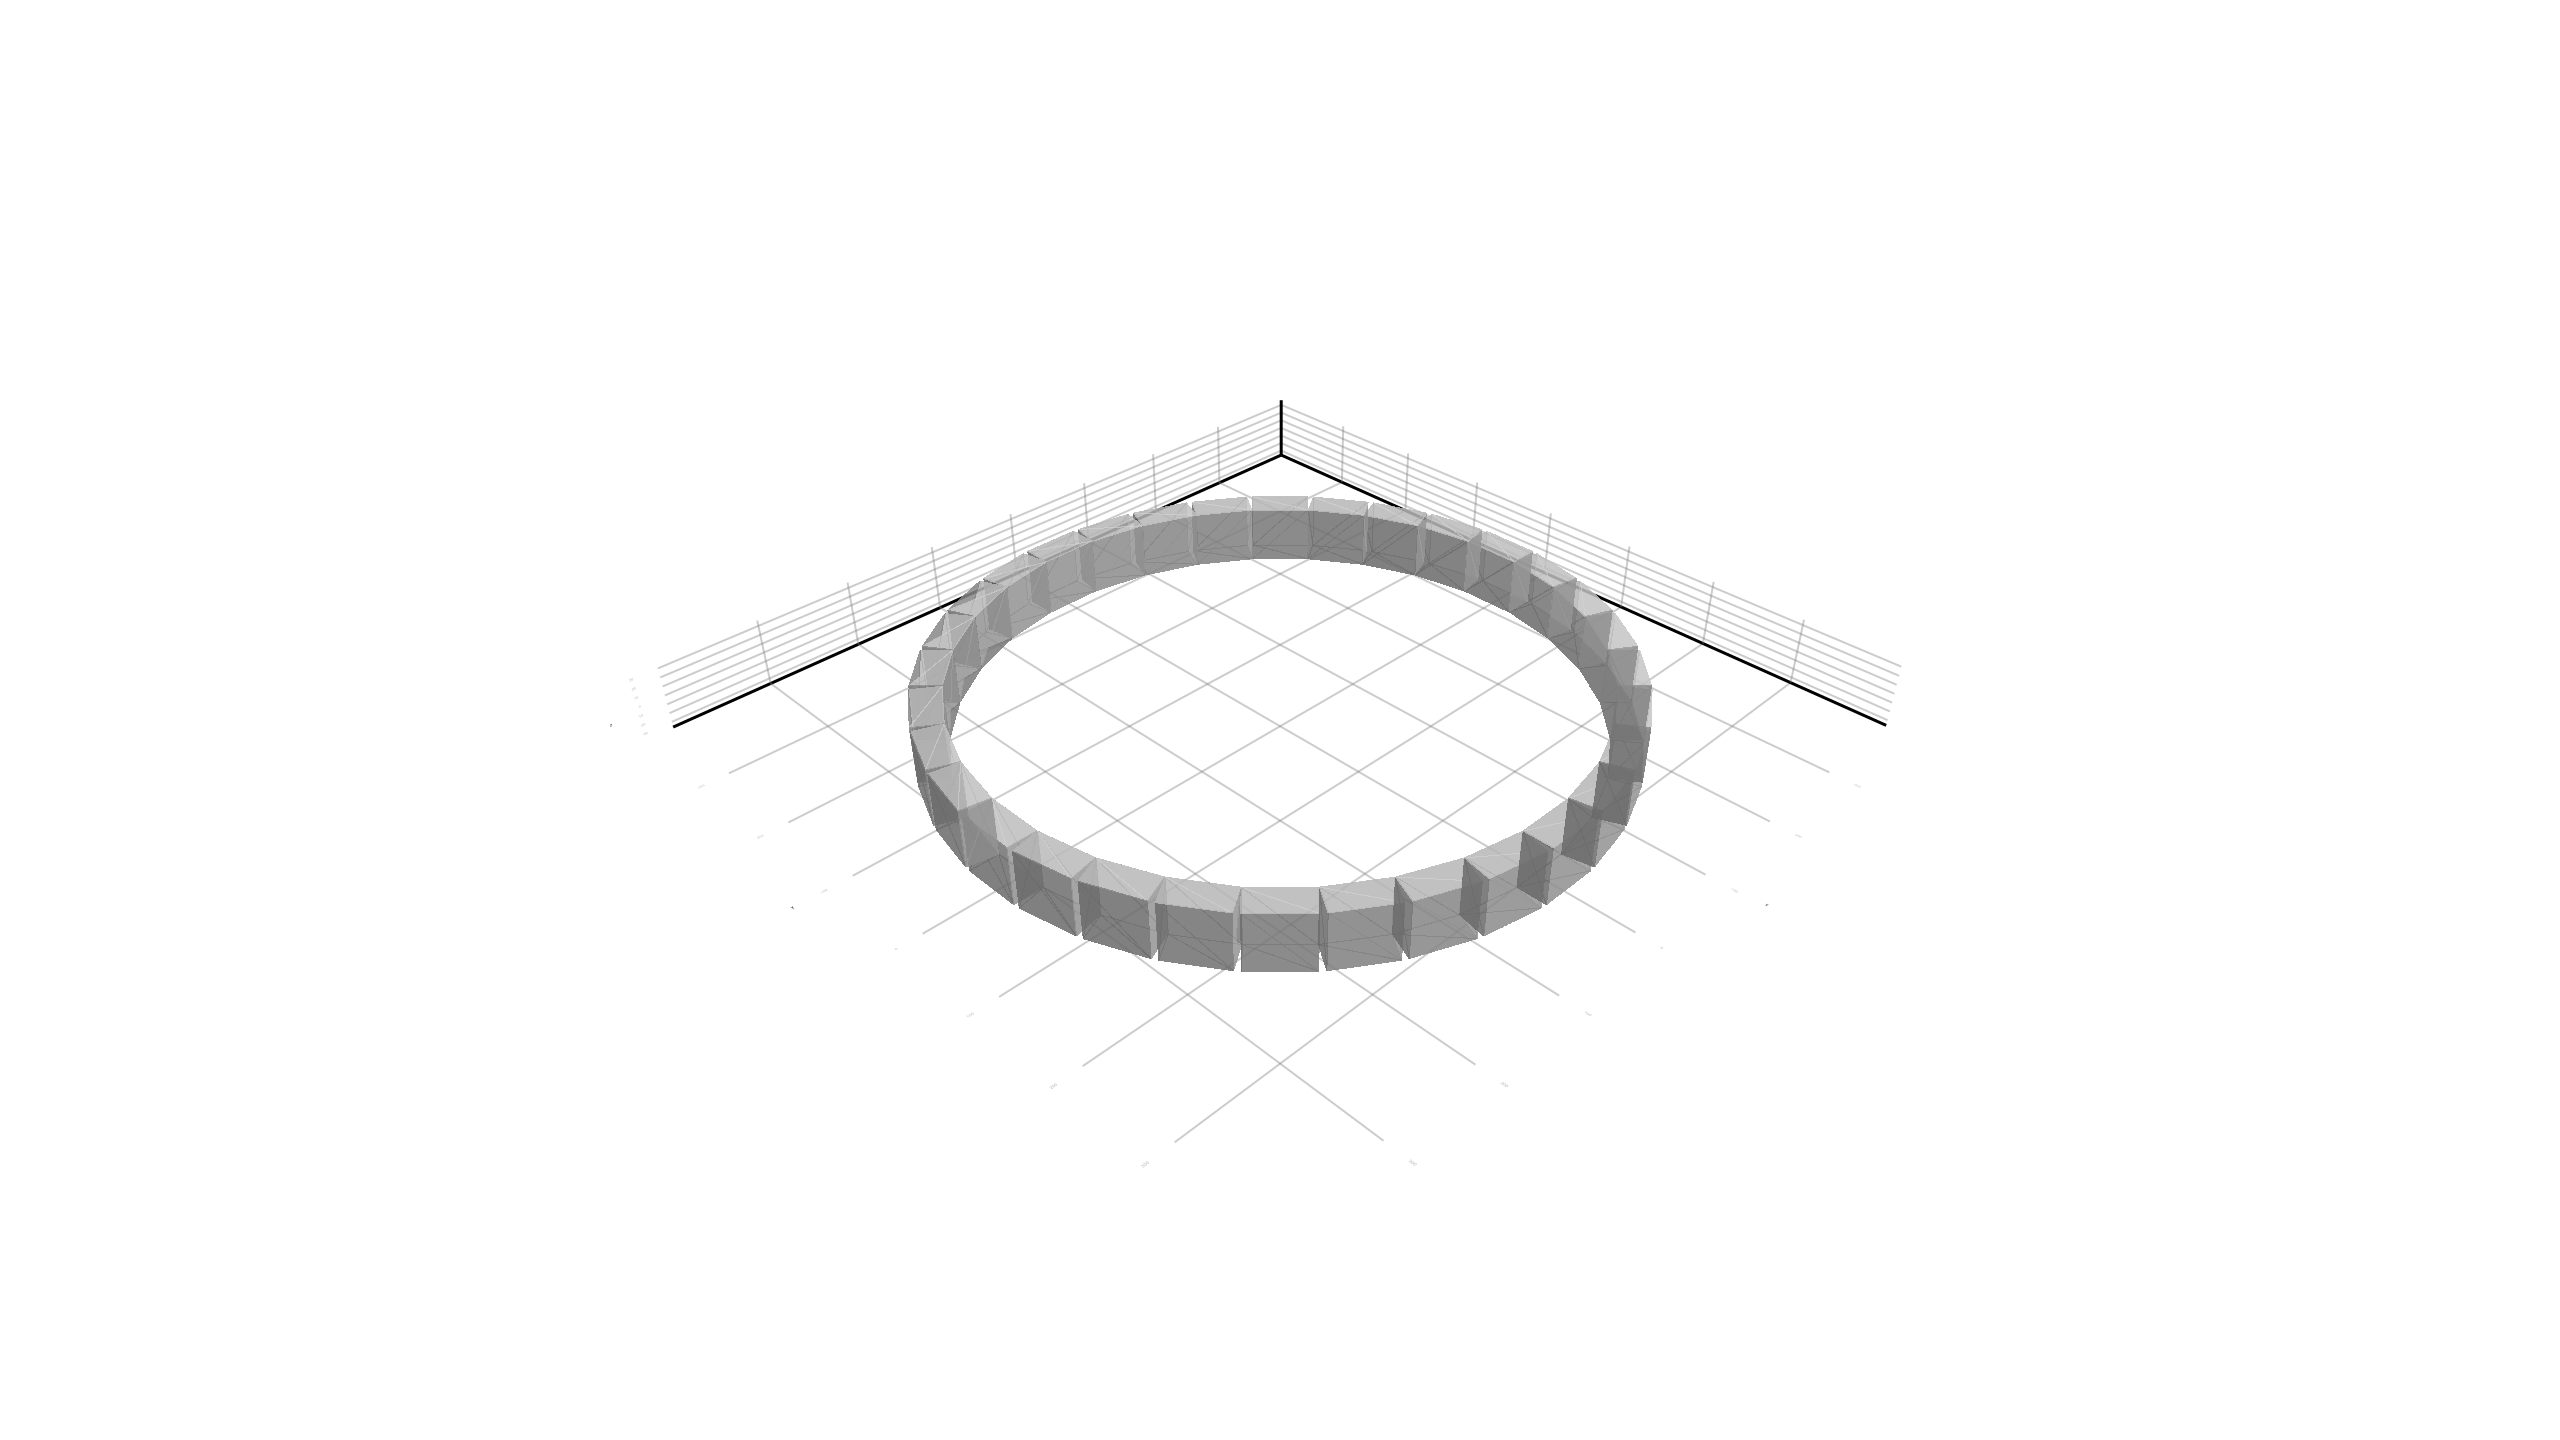

In [13]:
img = draw(logicRing)
display("image/png", img)

## Building the full detector

The detector construction is triggered by the `G4RunManager` at the right moment during the initialization steps. For this the user needs to provide a *detector constructor* function that will be called by the toolkit. The signature of the function is 
```
function construct(det::<DetectorParameters>)::CxxPtr{G4VPhysicalVolume}
   ...
   return world
end
```
It receives an instance of a user defined structure with all the parameters of the detector and returns a 'pointer' to the 'world' physical volume. The user needs to declare the constructor function by defining a function specific to the Parameters structure like this: 
```
Geant4.getConstructor(::<DetectorParameters>)::Function = construct
```
Here is a an  example:

In [14]:
using Parameters   # we use the Parameters package to be able to define structure with keyword arguments with defaults

@with_kw mutable struct DetectorB3 <: G4JLDetector
    cryst_dX::Float64 = 6cm
    cryst_dY::Float64 = 6cm
    cryst_dZ::Float64 = 3cm
    nb_cryst::Int32 = 32
    nb_rings::Int32 = 9
    patient_radius::Float64 = 8cm
    patient_dZ::Float64 = 10cm
    checkOverlaps::Bool = false
end

detector = DetectorB3(nb_cryst = 64)

DetectorB3
  cryst_dX: Float64 60.0
  cryst_dY: Float64 60.0
  cryst_dZ: Float64 30.0
  nb_cryst: Int32 64
  nb_rings: Int32 9
  patient_radius: Float64 80.0
  patient_dZ: Float64 100.0
  checkOverlaps: Bool false


then we define the detector constructor function which includes the material definitions, and eventually the visualization attributes

In [15]:
function construct(det::DetectorB3)::G4VPhysicalVolume
    (; cryst_dX, cryst_dY, cryst_dZ, nb_cryst, nb_rings, patient_radius, checkOverlaps, patient_dZ) = det

    #---Derived parameters-------------------------------------------------------------------------
    dPhi = 2π/nb_cryst 
    half_dPhi = 0.5*dPhi
    cosdPhi = cos(half_dPhi)
    tandPhi = tan(half_dPhi)
    ring_R1 = 0.5*cryst_dY/tandPhi
    ring_R2 = (ring_R1+cryst_dZ)/cosdPhi
    detector_dZ = nb_rings*cryst_dX
    world_sizeXY = 2.4*ring_R2
    world_sizeZ  = 1.2*detector_dZ
  
    #---Materials----------------------------------------------------------------------------------
    nist = G4NistManager!Instance()
    default_mat = FindOrBuildMaterial(nist, "G4_AIR")
    cryst_mat   = FindOrBuildMaterial(nist, "Lu2SiO5")
    
    #---Volumes------------------------------------------------------------------------------------
    solidWorldS = G4Box("world", world_sizeXY/2, world_sizeXY/2, world_sizeZ/2)
    logicWorld  = G4LogicalVolume(solidWorldS, default_mat, "World")
    physWorld   = G4PVPlacement(nothing, 
                                G4ThreeVector(),                # at (0,0,0)
                                logicWorld,                     # its logical volume
                                "World",                        # its name
                                nothing,                        # its mother  volume
                                false,                          # no boolean operations
                                0,                              # copy number
                                checkOverlaps)                  # checking overlaps

    solidRing = G4Tubs("Ring", ring_R1, ring_R2, cryst_dX/2, 0., 2π)
    logicRing = G4LogicalVolume(solidRing, default_mat, "Ring")

    gap = 0.5mm 
    dX = cryst_dX - gap
    dY = cryst_dY - gap
    solidCryst = G4Box("crystal", dX/2, dY/2, cryst_dZ/2)
    logicCryst = G4LogicalVolume(solidCryst, cryst_mat, "CrystalLV")

    # place crystals within a ring
    for icrys in 0:nb_cryst-1
      ϕ = icrys*dPhi
      rotm  = G4RotationMatrix()
      rotateY(rotm, π/2)
      rotateZ(rotm, ϕ)
      position = (ring_R1 + cryst_dZ/2) * G4ThreeVector(cos(ϕ), sin(ϕ), 0)
      transform = G4Transform3D(rotm, position)
  
      G4PVPlacement(transform,             # rotation,position
                    logicCryst,            # its logical volume
                    "crystal",             # its name
                    logicRing,             # its mother  volume
                    false,                 # no boolean operation
                    icrys,                 # copy number
                    checkOverlaps)         # checking overlaps
    end
  
    # full detector
    solidDetector = G4Tubs("Detector", ring_R1, ring_R2, detector_dZ/2, 0., 2π)
    logicDetector = G4LogicalVolume(solidDetector, default_mat, "Detector")

    # place rings within detector
    OG = -0.5*(detector_dZ + cryst_dX)
    for iring in 0:nb_rings-1
      OG += cryst_dX
      G4PVPlacement(nothing,                  # no rotation
                    G4ThreeVector(0, 0, OG),  # position
                    logicRing,                # its logical volume
                    "ring",                   # its name
                    logicDetector,            # its mother  volume
                    false,                    # no boolean operation
                    iring,                    # copy number
                    checkOverlaps)            # checking overlaps
    end
    
    # place detector in world
    G4PVPlacement(nothing,                  # no rotation
                  G4ThreeVector(),          # at (0,0,0)
                  logicDetector,            # its logical volume
                  "Detector",               # its name
                  logicWorld,               # its mother  volume
                  false,                    # no boolean operation
                  0,                        # copy number
                  checkOverlaps)            # checking overlaps

    # patient
    patient_mat = FindOrBuildMaterial(nist, "G4_BRAIN_ICRP")
    solidPatient = G4Tubs("Patient", 0., patient_radius, patient_dZ/2, 0., 2π)
    logicPatient = G4LogicalVolume(solidPatient, patient_mat,"PatientLV")
    G4PVPlacement(nothing  ,                # no rotation
                  G4ThreeVector(),          # at (0,0,0)
                  logicPatient,             # its logical volume
                  "Patient",                # its name
                  logicWorld,               # its mother  volume
                  false,                    # no boolean operation
                  0,                        # copy number
                  checkOverlaps)            # checking overlaps
                

    #---Visualization attributes-------------------------------------------------------------------
    SetVisAttributes(logicWorld, G4VisAttributes!GetInvisible())
    SetVisAttributes(logicRing, G4VisAttributes!GetInvisible())
    SetVisAttributes(logicDetector, G4VisAttributes!GetInvisible())

    #---Always return the physical world-----------------------------------------------------------
    return physWorld
end

construct (generic function with 1 method)

In [16]:
world = construct(detector)

Geant4.G4PVPlacementAllocated(Ptr{Nothing} @0x000000028acdd4c0)

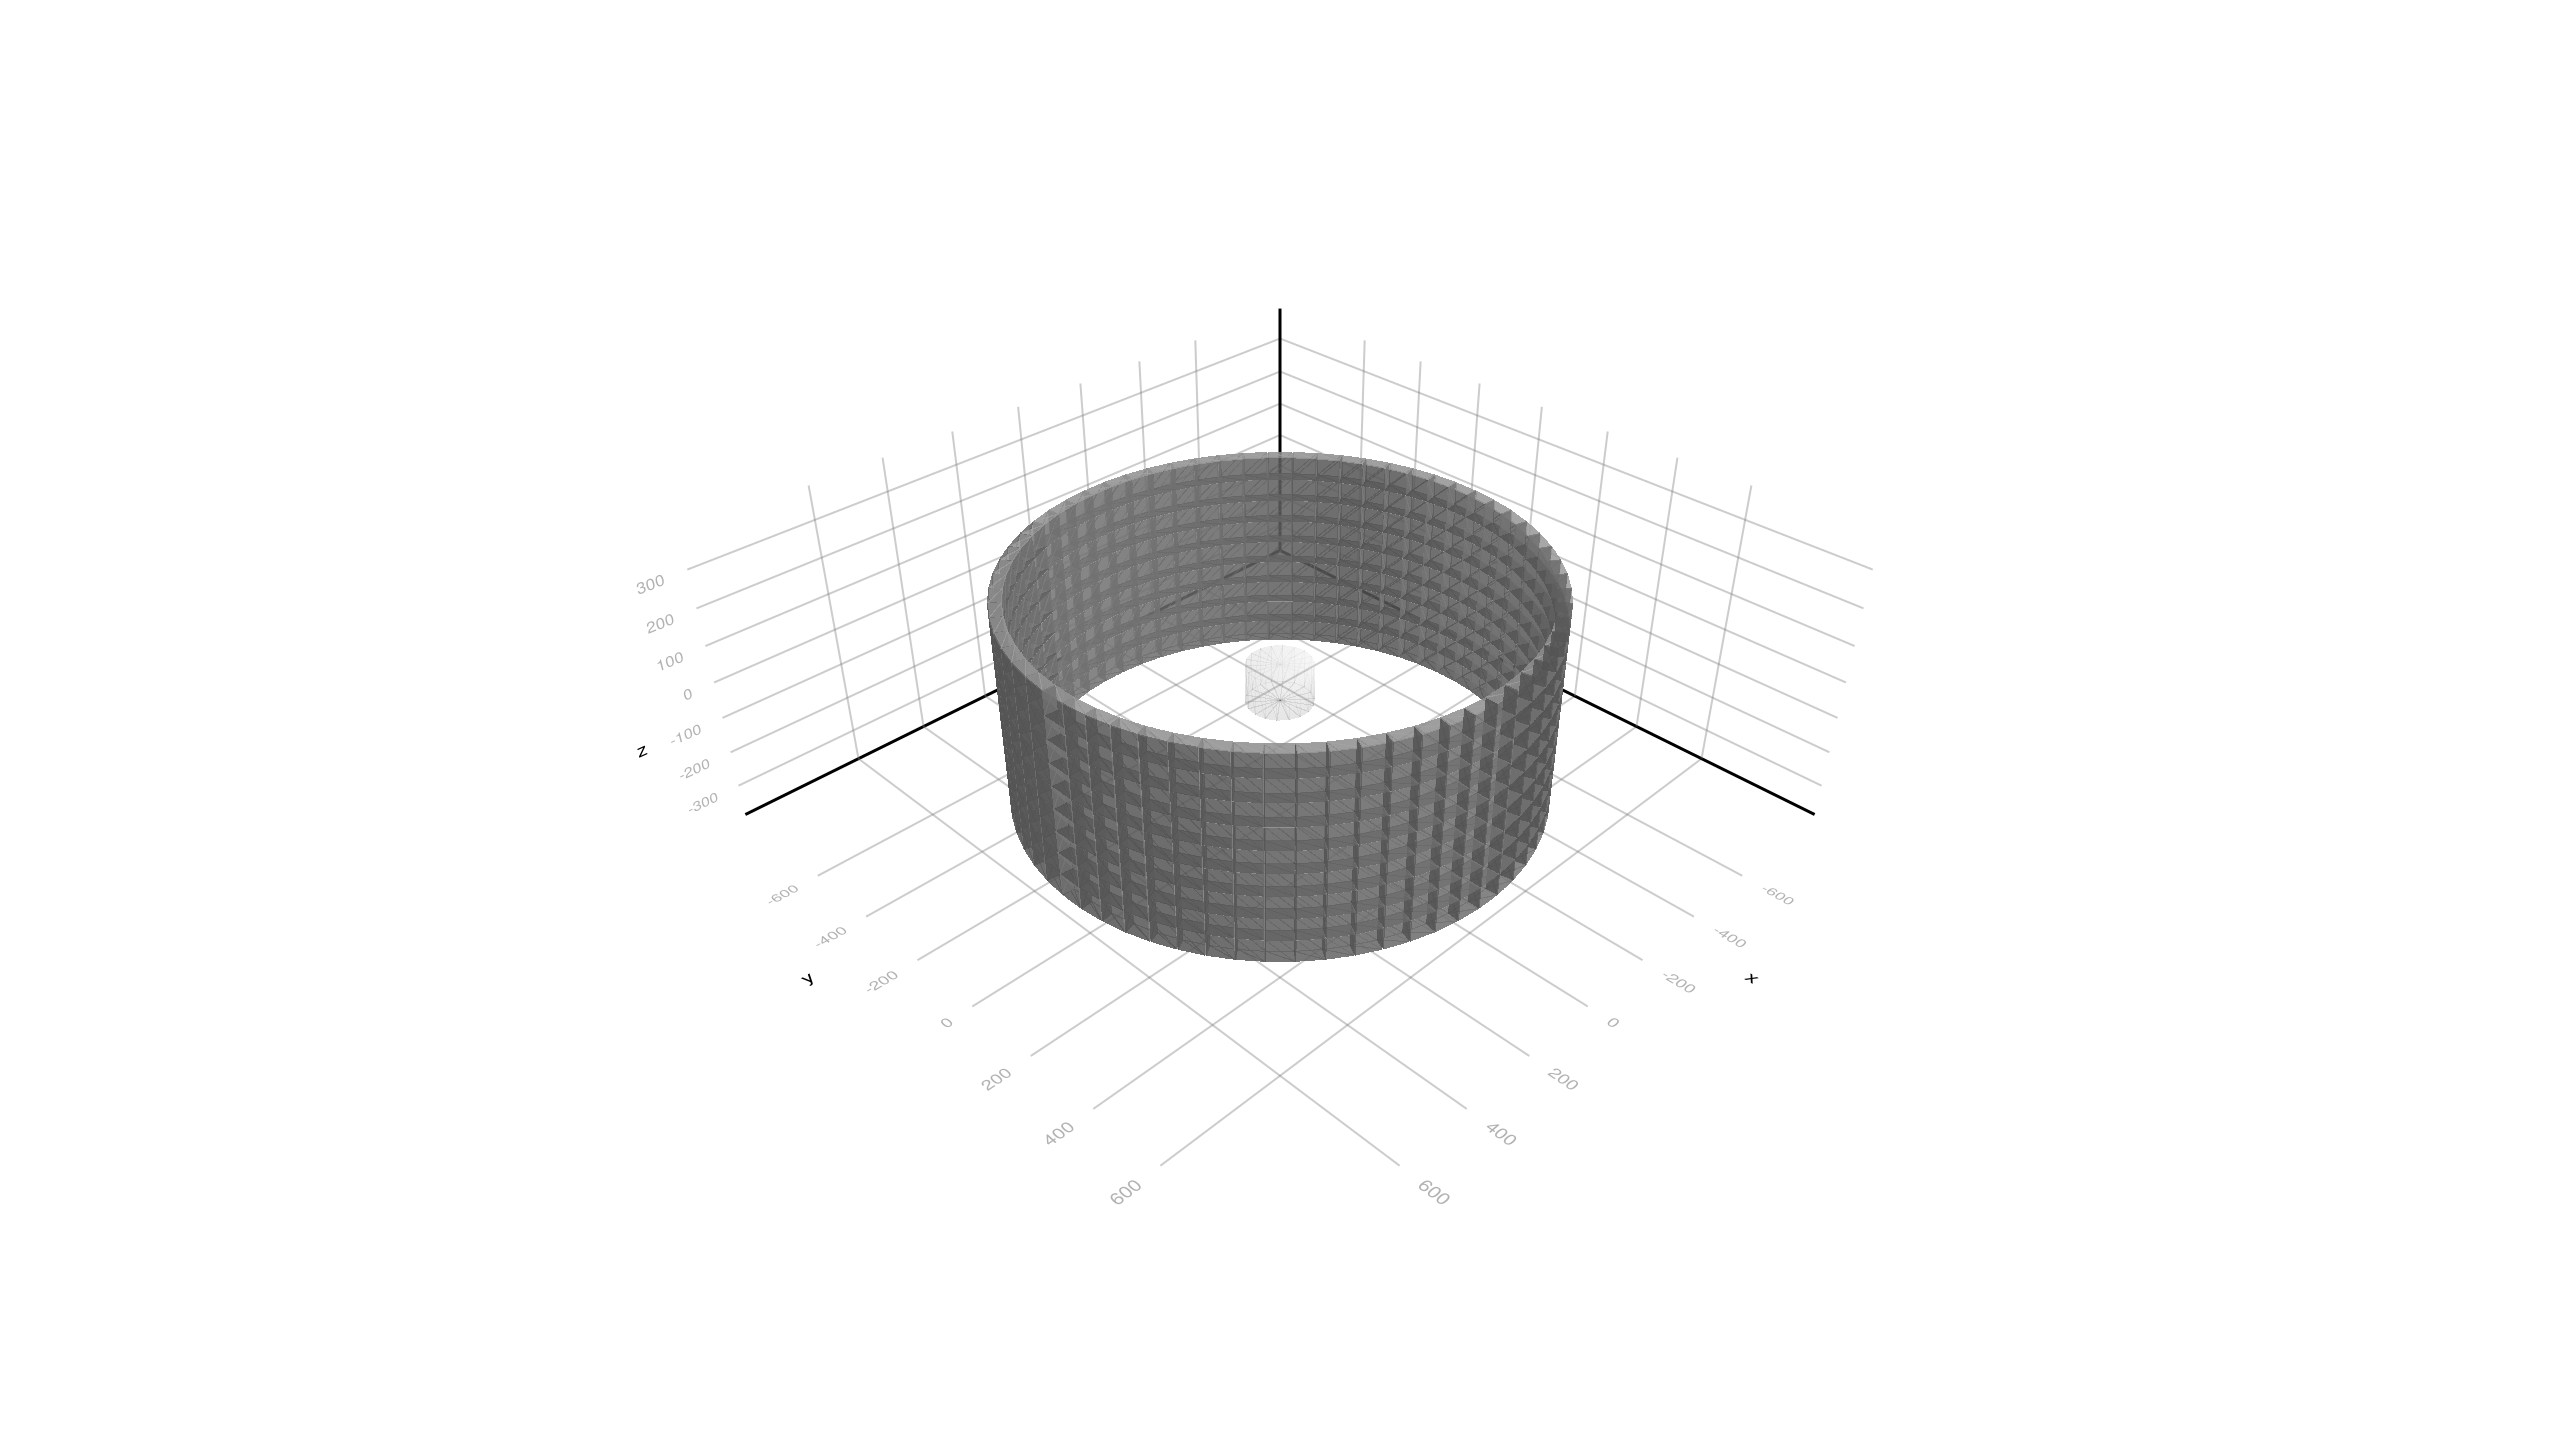

In [17]:
img = draw(world)
display("image/png", img)